In [1]:
import ROOT
from ipywidgets import interact, IntSlider, IntText
from itertools import takewhile, count

f = ROOT.TFile('/Users/atfienberg/g-2/nearlineTests/fitDisplays/run1462FirstTwoSubsFitDisplayCalo19.root')
module_label = 'fitDisplay'

if not ROOT.gROOT.FindObject('canv'):
    c = ROOT.TCanvas('canv', 'canv', 1000, 600)
if not ROOT.gROOT.FindObject('splitcanv'):
    split_c = ROOT.TCanvas('splitcanv', 'splitcanv', 1200, 800)
    split_c.Divide(9, 6, 0, 0)
sgen = takewhile(lambda s: isinstance(s, ROOT.TSpline3), 
                         (f.Get('{0}/splines/spline{1}'.format(module_label, i)) 
                          for i in count()))
splines = list(sgen)
t = f.Get('{}/fits/fitTree'.format(module_label))
n_entries = t.BuildIndex('fillNum', 'islandNums[0]*(xtalNum == 0 && subRunNum == 0) - 1*(xtalNum!=0)')

# need global handle to currently plotted objects so that they don't get garbage collected
plotted_objects = None

Welcome to JupyROOT 6.08/06


In [2]:
# define plotting functions

def plot_fit(entry_num, canvas, single=True, grid_index=0):
    t.GetEntry(entry_num)
    # build graph
    sample_g = ROOT.TGraph(0)
    sample_g.SetName('g{}'.format(grid_index))
    if single:
        if len(t.islandNums) == 1:
            sample_g.SetTitle('run {0}, subrun {4}, fill {2}, island {3}, xtal {1}; sample num; adc counts'.
                              format(t.runNum, t.xtalNum, t.fillNum, t.islandNums[0], t.subRunNum))
        else:
            sample_g.SetTitle('run {0}, subrun {4}, fill {2}, islands{3}, xtal {1}; sample num; adc counts'.
                              format(t.runNum, t.xtalNum, t.fillNum, 
                                     ''.join(' ' + str(num) for num in t.islandNums), t.subRunNum))
    sample_g.SetMarkerStyle(20)
    if single:
        sample_g.SetMarkerSize(0.5)
    sample_g.SetMarkerColor(ROOT.kBlack)
    sample_times = sum((list(range(first, first+length)) for first, length in zip(t.firstSampleNums, t.islandLengths)),
                       [])

    for sample_time, samp in zip(sample_times, t.trace):
        sample_g.SetPoint(sample_g.GetN(), sample_time, samp)
    
    # build fit function
    try:
        spline = splines[t.xtalNum]
    except IndexError:
        print('no spline found for segment {}!'.format(t.xtalNum))
        return
    
    # need to copy parameters or closure doesn't work as intended
    energies = [e for e in t.energies]
    times = [float(t0) for t0 in t.times]
    ped = float(t.pedestal)
    def fit_func(x):
        val = ped
        for (energy, t0) in zip(energies, times):
            if spline.GetXmin() < (x[0]-t0) < spline.GetXmax():
                val += -1*energy*spline.Eval(x[0]-t0)
        return val
    
    # draw graph and fit 
    sample_g.Draw("ap")
    x_min, x_max = (t.firstSampleNums[0], t.firstSampleNums[-1] + t.islandLengths[-1])
    y_min, y_max = (sample_g.GetYaxis().GetXmin(), sample_g.GetYaxis().GetXmax())
    sample_g.GetXaxis().SetLimits(x_min, x_max)
    if not single:
        # scale based on ADC range for grid plot
        sample_g.GetYaxis().SetRangeUser(-2047, 2048)
    fitTF1 = ROOT.TF1('fitfunc{}'.format(grid_index), fit_func, x_min, x_max, 0)
    fitTF1.SetNpx(1000)
    fitTF1.SetLineColor(ROOT.kMagenta + 2)
    # don't draw failed fits
    if t.chi2 > 0:
        fitTF1.Draw("p same")
    
    if not single:
        sample_g.GetXaxis().SetLabelOffset(999)
        sample_g.GetYaxis().SetLabelOffset(999)
        return (sample_g, fitTF1)

    # make text box
    x_range, y_range = (x_max - x_min, y_max - y_min)
    txtbox = ROOT.TPaveText(x_min + 0.5*x_range, y_min + 0.6*y_range, 
                            x_min + 0.9*x_range, y_min + 0.1*y_range)
    txtbox.SetFillColor(ROOT.kWhite)
    txtbox.SetLineColor(ROOT.kWhite)
    txtbox.SetShadowColor(ROOT.kWhite)
    for (i, (energy, t0)) in enumerate(zip(t.energies, t.times)):
        txtbox.AddText('t_{{{0}}}: {1:0.3f}'.format(i, t0))
        txtbox.AddText('E_{{{0}}}: {1:0.1f}'.format(i, energy))
    txtbox.AddText('pedestal: {:0.1f}'.format(t.pedestal))
    txtbox.AddText('#chi^{{2}}: {:0.1f}'.format(t.chi2))
    sample_g.GetYaxis().SetTitleOffset(2)
#    txtbox.Draw()
    canvas.Draw()
    return (sample_g, fitTF1, txtbox)

def plot_one_with_index(fill_num, island_num, xtal_num):
    ROOT.gStyle.SetOptTitle(1)
    entry_num = t.GetEntryNumberWithIndex(fill_num, island_num)
    if entry_num != -1L:
        c.cd()
        global plotted_objects
        plotted_objects = plot_fit(entry_num + xtal_num, c)
    else:
        print('entry not found in index')

def plot_grid_with_index(fill_num, island_num):
    ROOT.gStyle.SetOptTitle(0)
    entry_num = t.GetEntryNumberWithIndex(fill_num, island_num)
    if entry_num != -1L:
        # have to make sure objects are not garbage collected
        objects = []
        for xtal_num in xrange(54):
            split_c.cd(54 - xtal_num)
            objects.append(plot_fit(entry_num, split_c, single=False, grid_index=xtal_num))
            entry_num += 1
        split_c.Draw()
        global plotted_objects
        plotted_objects = objects
        print('first sample is at {} ns'.format(t.firstSampleNums[0]*1.25))
    else:
        print('entry not found in index')

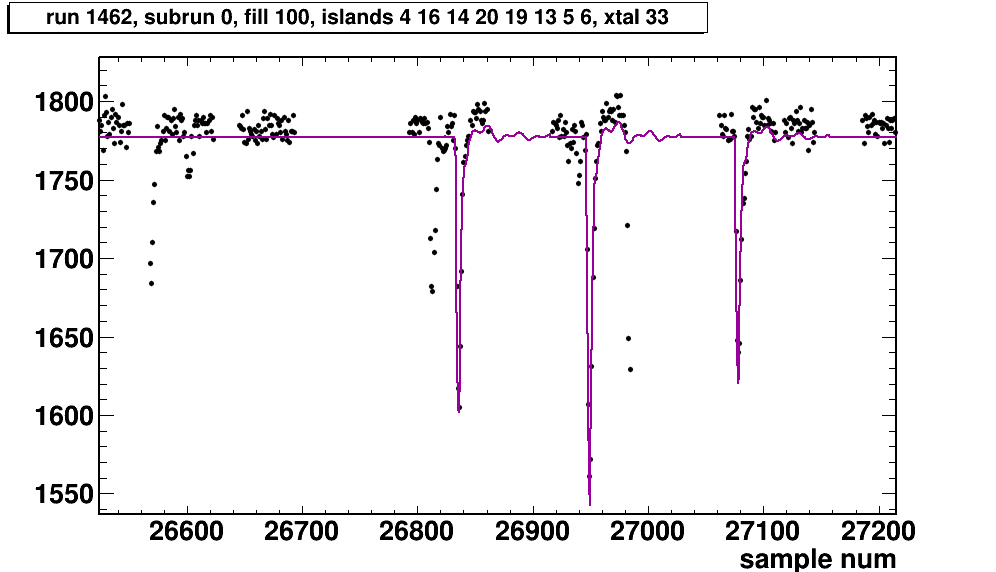

In [3]:
%jsroot off
dummy = interact(plot_one_with_index, fill_num=IntSlider(min=1, max=8000, step=1, value=100), 
                 island_num=IntSlider(min=0, max=100, step=1, value=4), 
                 xtal_num=IntSlider(min=0, max=len(splines) - 1, step=1, value=33))

first sample is at 83505.0 ns


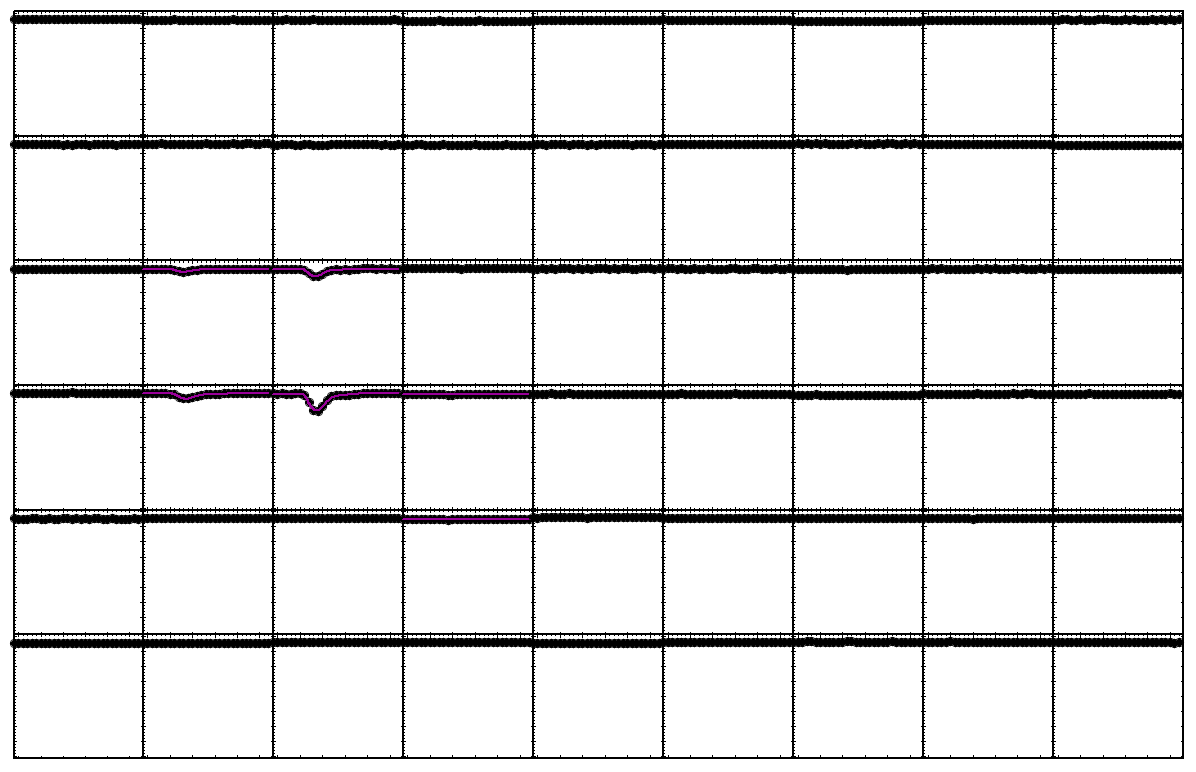

In [4]:
%jsroot off
dummy = interact(plot_grid_with_index, fill_num=IntText(min=1, value=100), 
                 island_num=IntText(min=0, value=10))

In [5]:
for e in t:
    samples = sorted(sum((list(range(first, first+length)) for first, length in zip(e.firstSampleNums, e.islandLengths)),
                       []))
    if (samples[0]*1.25 > 40000 and samples[0] < 80000 and e.xtalNum == 0 and e.fillNum == 110):
        print e.fillNum
        print e.islandNums[0]
        print e.subRunNum

In [6]:
# print island ranges for an event
event = 100
ranges = []
for e in t:
    if e.fillNum == event and e.xtalNum == 0 and e.subRunNum == 0:
        ranges.append(sorted(sum((list(range(first, first+length)) for first, length in zip(e.firstSampleNums, e.islandLengths)),
                       [])))
    if e.fillNum > event:
        break
ranges = sorted(ranges, key=lambda x: x[0])
for r in ranges:
    print '[{0},{1}]'.format(r[0]*1.25-1070, r[-1]*1.25-1070)

[5168.75,5208.75]
[31005.0,31036.25]
[31041.25,31120.0]
[31242.5,31790.0]
[31811.25,31888.75]
[31951.25,32055.0]
[32085.0,32947.5]
[33695.0,33726.25]
[34011.25,34041.25]
[34501.25,34531.25]
[37306.25,37357.5]
[40728.75,40758.75]
[55121.25,55152.5]
[82435.0,82470.0]
[150172.5,150207.5]
[178262.5,178300.0]
[687078.75,687110.0]


In [7]:
t.GetEntry(0)
print(t.fillNum)

39
